In [1]:
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import ResNet50

In [2]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 25
IMG_DIR = pathlib.Path('G:\Github\standford-dogs\cropped')
TRAIN_DIR = 'G:/Github/standford-dogs/cropped/train'
VAL_DIR = 'G:/Github/standford-dogs/cropped/validation'

Specifiy model

In [3]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)


In [4]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 16464 images belonging to 120 classes.
Found 4116 images belonging to 120 classes.


In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [6]:
res_name[-22:]

['conv5_block2_1_conv',
 'conv5_block2_1_bn',
 'conv5_block2_1_relu',
 'conv5_block2_2_conv',
 'conv5_block2_2_bn',
 'conv5_block2_2_relu',
 'conv5_block2_3_conv',
 'conv5_block2_3_bn',
 'conv5_block2_add',
 'conv5_block2_out',
 'conv5_block3_1_conv',
 'conv5_block3_1_bn',
 'conv5_block3_1_relu',
 'conv5_block3_2_conv',
 'conv5_block3_2_bn',
 'conv5_block3_2_relu',
 'conv5_block3_3_conv',
 'conv5_block3_3_bn',
 'conv5_block3_add',
 'conv5_block3_out',
 'max_pool',
 'flatten']

In [7]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 120

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               123000    
Total params: 26,858,488
Trainable params: 12,202,104
Non-trainable params: 14,656,384
___________________________________

We chose to use resnet50 as feature extraction, hence adding pooling layer

In [10]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [11]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [12]:
model.fit(train_generator,steps_per_epoch=np.ceil(float(16464) / float(BATCH_SIZE)),
                        epochs = 100,callbacks=[early_stop,reduce_lr],
                          validation_steps=np.ceil(float(4116) / float(BATCH_SIZE)),
                        validation_data = validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 659.0 steps, validate for 165.0 steps
Epoch 1/100
659/659 [==============================] - 296s 449ms/step - loss: 5.5431 - accuracy: 0.0202 - f1_score: 0.0173 - val_loss: 4.1658 - val_accuracy: 0.1319 - val_f1_score: 0.0800
Epoch 2/100
659/659 [==============================] - 268s 407ms/step - loss: 4.0111 - accuracy: 0.1269 - f1_score: 0.1048 - val_loss: 2.3865 - val_accuracy: 0.4320 - val_f1_score: 0.3750
Epoch 3/100
659/659 [==============================] - 205s 311ms/step - loss: 3.0336 - accuracy: 0.2769 - f1_score: 0.2590 - val_loss: 1.6469 - val_accuracy: 0.5624 - val_f1_score: 0.5182
Epoch 4/100
659/659 [==============================] - 204s 309ms/step - loss: 2.3992 - accuracy: 0.3892 - f1_score: 0.3745 - val_loss: 1.2363 - val_accuracy: 0.6567 - val_f1_score: 0.6370
Epoch 5/100
659/659 [==============================] - 204s 309ms/step - loss: 2.0096 - accuracy: 0.4670 - f1_score: 0.4543 - val_loss: 1.1838 - v

In [13]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

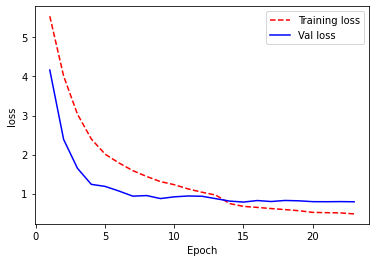

In [14]:
get_diagnostic_plot(model,'loss')

get_diagnostic_plot(model,'accuracy')

In [15]:
save_path = 'G:/Github/Dogs_breed_classification/resnet50_4/'
tf.keras.models.save_model(model,save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: G:/Github/Dogs_breed_classification/resnet50_4/assets


In [16]:
f1_score_history = model.history.history['f1_score']

In [17]:
f1_scores = [np.mean(item) for item in  f1_score_history]

In [18]:
f1_score_val_hist = model.history.history['val_f1_score']

In [19]:
f1_scores_val = [np.mean(item) for item in  f1_score_val_hist]

Text(0, 0.5, 'F1 Score')

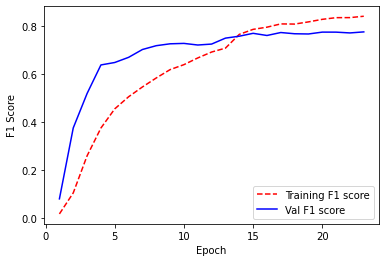

In [20]:
training_loss = f1_scores
test_loss = f1_scores_val

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training F1 score', 'Val F1 score'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

This result is almost the same v.s. our first model using Resnet for extraction only

=> model indicates high variability 

We can:
   * Add more data (increase train split ratio, probbaly 9:1 would work for this set)
   * Regularization (try more drop outs and strides)
   * Or We shall move on with other model structures other than Resnet 50